# Homework 2 - balancing & binning (deadline 28. 11. 2020)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
  1. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance.
  1. Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. **Just copied code from tutorial 4 will not be accepted.**
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results (give a comment).
  
Give comments (!) on each step of your solution, with short explanations of your choices.

**If you do all this properly, you will obtain 16 points.** 

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.
  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task, the aim is to predict the probability that a driver will initiate an auto insurance claim in the next year.
* Target feature is called 'y' and signifies whether or not a claim was filed for that policy holder.
* To fulfill the task one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

# Here comes my code

### Libraries Imports

In [1]:
import pandas as pd

from collections import namedtuple
from math import ceil, floor

import numpy as np
from numpy import where # Otherwise ValueError: Input contains NaN, infinity or a value too large for dtype('float32')

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

import matplotlib.pyplot as plt

import seaborn as sns

import pickle

In [2]:
# Constants - having them here protects me from using one abbreviation for multiple purposes
MV = "missing_values"
PM = "percentage_missing"
UV = "unique_values"
# Randomness
SEED = 42
# Training
TEST_SET_RATIO    = 0.2
VALIDATION_SET_RATIO = 0.2

IDX = 6

TRAIN_SAMPLE_SIZE = [20, 130, 905, 5629, 17472, 34710, 44053][IDX]
FEATURES_NUMBER   = [5, 8, 11, 18, 57, 227, 227][IDX]
HIDDEN_NEURONS    = [3, 5, 25, 100, 100, 100, 100][IDX]

SAMPLES_NUMBER    = ceil(TRAIN_SAMPLE_SIZE / (1 - TEST_SET_RATIO))

In [3]:
# Prepare namedtuples for easier data manipulation
Dataset = namedtuple("Dataset", ["name", "X", "y"])

Classifier = namedtuple("Classifier", ["name", "estimator"])

Model = namedtuple("Model", ["classifier", "train_set", "test_set", "y_prediction"])

Evaluation = namedtuple("Evaluation", ["data_name", "model_name", "accuracy", "auc", "f1_score"])

Balancer = namedtuple("Balancer", ["name", "method"])

In [4]:
CLASSIFIERS = (
    Classifier("decision_tree",         DecisionTreeClassifier(random_state=SEED)),
    Classifier("naive_bayes",           GaussianNB()),
    Classifier("logistic_regression",   LogisticRegression(max_iter=1000, random_state=SEED)),
    Classifier("multilayer_perceptron", MLPClassifier(alpha=1, max_iter=1000, random_state=SEED)),
)

### Data Cleansing Functions

In [5]:
def dropHalfEmptyColumns(df, MAX_MISSING_RATIO = 0.10):
    """Drop columns with high percentage of missing values.
    MAX_MISSING_RATIO defines maximum percentage of missing values per feature.
    """

    df_tmp = df.apply(lambda x: (x == -1).sum())
    drop_columns = df_tmp[df_tmp > df.shape[0]*MAX_MISSING_RATIO].index
        
    return df.drop(drop_columns, axis=1)

def getCategoricalColumns(df):
    """Return columns that their name ends with "_cat" """
    return np.array([x for x in df.columns if x.endswith("_cat")])

def dropHighCardinalityCategoricalFeatures(df, MAX_CATEGORICAL_CARDINALITY = 10):
    """Drop categorical features with too high cardinality.
    MAX_CATEGORICAL_CARDINALITY defines the maximum number of unique values per categorical feature.
    """
    cat_cols = getCategoricalColumns(df)

    drop_cols = cat_cols[df[cat_cols].nunique() >= MAX_CATEGORICAL_CARDINALITY]
    return df.drop(drop_cols, axis=1)    

def getEncodedCategoricalColumns(suffix, df):
    """Return columns with given suffix"""
    return [x for x in df.columns if x.endswith(str(suffix))]

def convertCategoricalFeatures(df):
    """Convert given columns to types to categorical type.
    Show types of categorical columns. Also show types of non-categorical features.
    """
    cols = getCategoricalColumns(df)
    df[cols] = df[cols].astype("category")
    
    print(f"Categorical columns types: {list({type(x) for x in df[cols].dtypes})}",
          f"Other columns types:       {df.drop(cols, axis=1).dtypes.unique()}\n", sep="\n")
    return df

def oneHotEncoding(df):
    """For categorical features perform one-hot encoding.
    Add the encoded features to given dataframe and drop the original (not-encoded) columns.
    """
    cols = df.dtypes[df.dtypes == "category"].index.values
    df = pd.concat([
        df.drop(cols, axis=1), 
        pd.get_dummies(df[cols])
    ], axis=1)
    print(f"Number of features after encoding: {df.shape[1]}")
    return df

def dropMissingValuesEncodedToFeatures(df):
    """Drop features representing missing values. Created by one-hot encoding"""
    drop_cols = getEncodedCategoricalColumns("-1", df)
    return df.drop(drop_cols, axis=1)

### Plotting Functions Wrappers

In [6]:
def showBarplotWithPercentages(x, y, df, total=None, title=f""):
    """Show barplot with bars in descending order and percentages on top"""
    df = df.sort_values(by=y, ascending=False)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.barplot(x=x, y=y, data=df, ax=ax, palette="muted")

    for p in ax.patches:
        if total is not None:
            annotation = '{:.1f}%'.format((p.get_height()/total) * 100) # percentage
        else:
            annotation = p.get_height()
        x = p.get_x() + p.get_width()/10
        y = int((p.get_y() + p.get_height()*1.005))
        ax.annotate(annotation, (x, y))

    ax.set_title(title)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
    return ax

def showHistogramAndBoxplot(feature, df, discrete):
    """Show histogram and boxplot for given dataframe feature"""
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 6)
    sns.histplot(x=feature, data=df, discrete=discrete, ax=axes[0]).set_title(f"Histogram of {feature} feature")
    sns.boxplot(x=feature, data=df, ax=axes[1]).set_title(f"{feature} feature boxplot")
#     sns.boxplot(df[feature].values, ax=axes[1]).set_title(f"{feature} feature boxplot")

### Exploration Functions

In [7]:
def showCategories(df, x="feature", y= UV):
    """Show barplot with sizes of categorical features"""
    cat_cols = getCategoricalColumns(df)
    data = df[cat_cols].nunique().reset_index().rename(columns={"index": x, 0: y})
    
    ax = showBarplotWithPercentages(x=x, y=y, df=data, total=None,
        title="Numbers of categorical features unique values")
    return ax

def showMissingValues(df, x="feature", y=MV):
    """Show barplot number of missing values per features"""
    data = df.apply(lambda x: (x == -1).sum()).reset_index().rename(columns={"index": x, 0: y})
    data = data[data[MV] > 0]

    ax = showBarplotWithPercentages(x=x, y=y, df=data, total=df.shape[0],
        title="Columns with missing values (-1) and percentages of missing values")
    return ax

def showCategoriesAndMissingValues(df, uv=UV, mv=MV, hue="feature"):
    """Show features scatter plot of unique and missing values"""
    cat_cols = getCategoricalColumns(df)
    
    data = pd.concat([
        df[cat_cols].nunique(),
        df[cat_cols].apply(lambda x: (x == -1).sum())
    ], axis=1).reset_index().rename(columns={"index": hue, 0: uv, 1: mv})

    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.scatterplot(x=uv, y=mv, hue=hue, data=data,s=500, palette="deep", ax=ax)
    _ = ax.set_title("Dependency of unique values number on missing values number (categorical cols)")
    return ax

def showSizesOfFeatureCategories(feature, df):
    """For given feature show size of its each category"""
    df[feature] # Test for key presence
    fig, ax = plt.subplots(figsize=(16, 10))
    ax = sns.countplot(x=feature, data=df, ax=ax)
    ax.set_title(f"\"{feature}\" categories sizes")
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
    return ax

### Binning

In [8]:
def binFeatureEqualWidth(feature, df, equal, interval_method):
    """Discretize feature into categories, either with fixed interval size, or with fixed number of samples"""

    interval_num = ceil(interval_method(df.xcar_13.nunique()))
    print(f"Number of Intervals: {interval_num}")

    bin_labels = list(range(interval_num))
    bin_feature = f"{feature}_{equal}_{interval_num}"
    print(f"Name of binned feature: {bin_feature}")
    
    bin_method = pd.qcut if equal == "depth" else pd.cut
    df[bin_feature] = bin_method(df[feature], interval_num, labels=bin_labels).cat.codes
    return bin_feature


### Model Training and Evaluation Functions 

In [9]:
def datasetsFromDataframes(name, train_df, test_df=None, drop_features=None):
    """Split dataframe(s) into features and target variable. Specified features may be dropped."""
    
    to_drop = ["y"]
    if (drop_features is not None):
        to_drop.extend(drop_features)

    train_ds = Dataset(name=name, X=train_df.drop(to_drop, axis=1), y=train_df.y)
    test_ds = Dataset(name=name, X=test_df.drop(to_drop, axis=1), y=test_df.y) if (test_df is not None) else None
    
    return train_ds, test_ds

In [10]:
def trainModel(classifier, train_set, test_set):
    print(f"\n[{classifier.name}] {train_set.name}")
    y_prediction =  classifier.estimator.fit(train_set.X, train_set.y).predict(test_set.X)
    return Model(classifier=classifier, y_prediction=y_prediction,
        train_set=train_set, test_set=test_set)

def getSample(df, samples_num=SAMPLES_NUMBER, features_num=FEATURES_NUMBER, balanced=False, seed=SEED):
    """Return sample of given dataframe"""

    # Chose random columns other than y
    np.random.seed(seed=seed)
    sample_cols = np.random.choice(df.drop("y", axis=1).columns.values, size=features_num, replace=False)

    if balanced:
        # Number of samples of every y category
        n = ceil(samples_num/df.y.nunique())
        # Copy SAMPLES_NUMBER samples of the data with the same number of samples for each y category
        sample_df = df.groupby("y").sample(n=n, random_state=seed, replace=False)[["y", *sample_cols]].copy()
    else:
        sample_df = df.sample(n=samples_num, random_state=seed, replace=False)[["y", *sample_cols]].copy()
    return sample_df

def evaluateModel(model):
    """Evaluate model with accuracy, auc and f1 scores and return Evaluation namedtuple"""
    ev = Evaluation(data_name=model.train_set.name, model_name=model.classifier.name,
        accuracy=accuracy_score(model.test_set.y, model.y_prediction),
        auc=roc_auc_score(model.test_set.y, model.y_prediction),
        f1_score=f1_score(model.test_set.y, model.y_prediction))
    print(f"{f'[{ev.model_name}]': <24} {ev.data_name: <24} Acc: {ev.accuracy:.5f}\tAUC: {ev.auc:.5f}\tF1: {ev.f1_score:.5f}")
    return ev

def showEvaluations(evals):
    """Show 2D grid of barplots, where x axis covers different scores and y covers different classifiers"""

    eval_df = pd.DataFrame(evals)
    df = eval_df

    df = pd.melt(df, id_vars=["data_name", "model_name"], 
        value_name="score_value").rename(columns={'variable':"score", "model_name":"model"})

    g = sns.FacetGrid(df, col="score", row="model", hue="score", sharex=False, height=2.4, aspect=1.8)
    _ = g.map(sns.barplot, "score_value", "data_name", order=None)

    for axes in g.axes:
        for ax in axes:
            for p in ax.patches:
                annotation = f"{p.get_width():.5}"
                x = (p.get_x() + p.get_width()/4)
                y = (p.get_y() + (p.get_height()/4)*3)
                ax.annotate(annotation, (x, y))    
    return g


## 1) Download the dataset

In [11]:
# Load the Dataframe
original_df = pd.read_csv('data.csv')

print(f"Shape of the original dataframe: {original_df.shape}")

Shape of the original dataframe: (595212, 58)


In [12]:
# Basic information about the loaded dataframe
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   y             595212 non-null  int64  
 1   xind_01       595212 non-null  int64  
 2   xind_02_cat   595212 non-null  int64  
 3   xind_03       595212 non-null  int64  
 4   xind_04_cat   595212 non-null  int64  
 5   xind_05_cat   595212 non-null  int64  
 6   xind_06_bin   595212 non-null  int64  
 7   xind_07_bin   595212 non-null  int64  
 8   xind_08_bin   595212 non-null  int64  
 9   xind_09_bin   595212 non-null  int64  
 10  xind_10_bin   595212 non-null  int64  
 11  xind_11_bin   595212 non-null  int64  
 12  xind_12_bin   595212 non-null  int64  
 13  xind_13_bin   595212 non-null  int64  
 14  xind_14       595212 non-null  int64  
 15  xind_15       595212 non-null  int64  
 16  xind_16_bin   595212 non-null  int64  
 17  xind_17_bin   595212 non-null  int64  
 18  xind

### Split the Dataframe into Train and Test Sets

- Test set will stay untouched until the final valuation

In [13]:
train_df, test_df = train_test_split(original_df.copy(), test_size=TEST_SET_RATIO, random_state=SEED).copy()

print(f"""Train Set and Test Set Sizes (rows, columns)
Train set: {train_df.shape}
Test set:  {test_df.shape}
""")

Train Set and Test Set Sizes (rows, columns)
Train set: (476169, 58)
Test set:  (119043, 58)



### Sample the Train Set for Testing Purposes

- Appropriate procedures and parameters may be found on smaller subset of the training set.
- It is not neccessary to use full training set to find the best candidates.
    - Validation set (created from the sample) will be used to identify the best candidates.

In [14]:
sample_number = max(2000, ceil(train_df.shape[0]*0.1))

train_sample_df = train_df.sample(n=sample_number, random_state=SEED)

print(f"Shape of the train sample dataframe (rows, columns): {train_sample_df.shape}")

Shape of the train sample dataframe (rows, columns): (47617, 58)


### Look at the y values

- The classification task is binary or multiclass classification?
- Are the classes of similar sizes?

In [15]:
value_counts = train_sample_df.y.value_counts()
y_classes = list(zip(value_counts.index.values, value_counts.values))

print(f"Number of samples for every y class (y, size):", *y_classes, sep="\n- ")

Number of samples for every y class (y, size):
- (0, 45926)
- (1, 1691)


## Data Cleansing

- This dataframe will be full of rules of thumb
- The goal is not be super objective or get super relevant resuls
- The goal is to provide some insight quickly, the relevance will be tested afterwards
- Convert Categorical Features to Categorical Type
- Check Type by the Column Name

In [16]:
train_sample_thumb_df = train_sample_df.copy()

### Explore Missing Values

The missing values are encoded with value `-1` so it is not visible at first glance how much values there are missing.

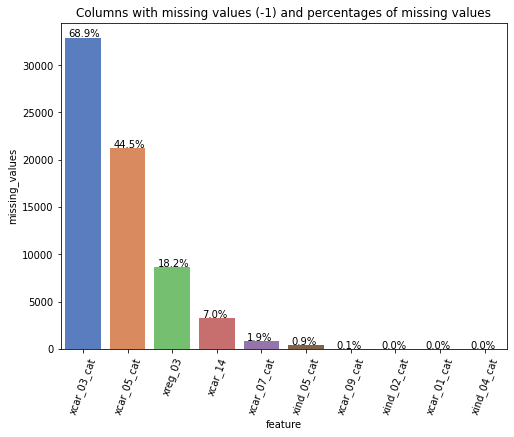

In [17]:
_ = showMissingValues(train_sample_df)

- The missing values should be treated separatedly.
    - Perhaps some imputation method should be used so the missing values would make sense.
    - Usually good choice is the k-Nearest Neighbors, however even the replacment with mean works better than just leaving there an artificial number.

- It does not need to be true, if the values are missing from some systematical reason, the reason can be explored.
    - For this analysis I will hope, the values are missing for a good reason, so I won't impute them anyhow.

### Drop columns with too many missing values

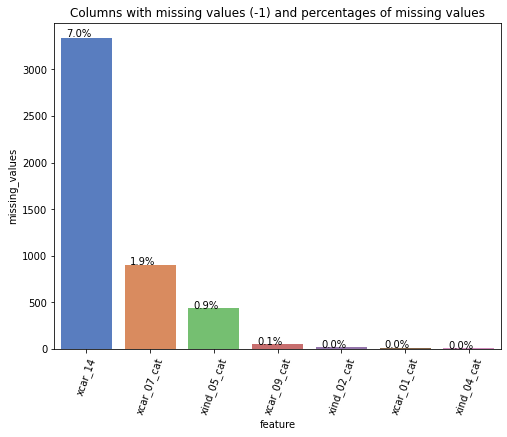

In [18]:
train_sample_thumb_df = dropHalfEmptyColumns(train_sample_thumb_df)

_ = showMissingValues(train_sample_thumb_df)

### Cardinality of Categorical Features

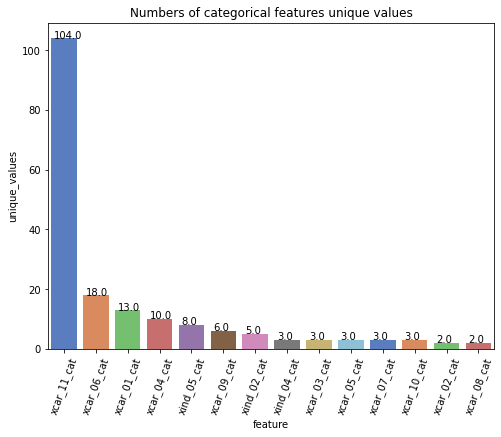

In [19]:
_ = showCategories(train_sample_df)

### Drop categorical columns with too many categories

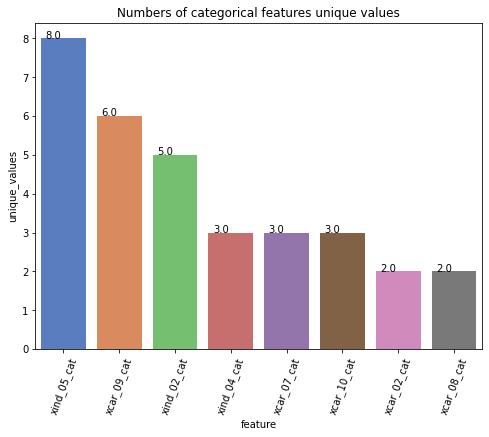

In [20]:
train_sample_thumb_df = dropHighCardinalityCategoricalFeatures(train_sample_thumb_df)

_ = showCategories(train_sample_thumb_df)

Columns with "_cat" suffix should be treated as cetegorical

### Convert Categorical Features to Categorical Type

In [21]:
train_sample_df = convertCategoricalFeatures(train_sample_df)

train_sample_thumb_df = convertCategoricalFeatures(train_sample_thumb_df)

Categorical columns types: [<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>]
Other columns types:       [dtype('int64') dtype('float64')]

Categorical columns types: [<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>]
Other columns types:       [dtype('int64') dtype('float64')]



### Make Categorical Columns Suitable for Classifiers

- Check if One-Hot encoding is possible (i.e. check whether the cardinality is not to high)

**Some columns has high cardinality let's look how much values are they miss**

- In case there would be significant percentage of missing values we could drop them with peace in mind
    - I'm not sure, this cardinality increase is worth one column of features

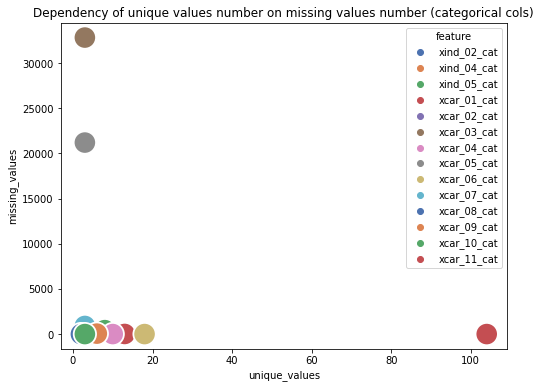

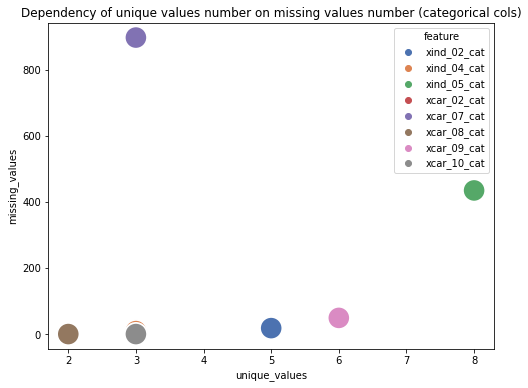

In [22]:
_ = showCategoriesAndMissingValues(train_sample_df)

_ = showCategoriesAndMissingValues(train_sample_thumb_df)

### Explore the categories sizes of categorical features

- Easy and interactive

Categorical columns: ['xind_02_cat' 'xind_04_cat' 'xind_05_cat' 'xcar_01_cat' 'xcar_02_cat'
 'xcar_03_cat' 'xcar_04_cat' 'xcar_05_cat' 'xcar_06_cat' 'xcar_07_cat'
 'xcar_08_cat' 'xcar_09_cat' 'xcar_10_cat' 'xcar_11_cat']



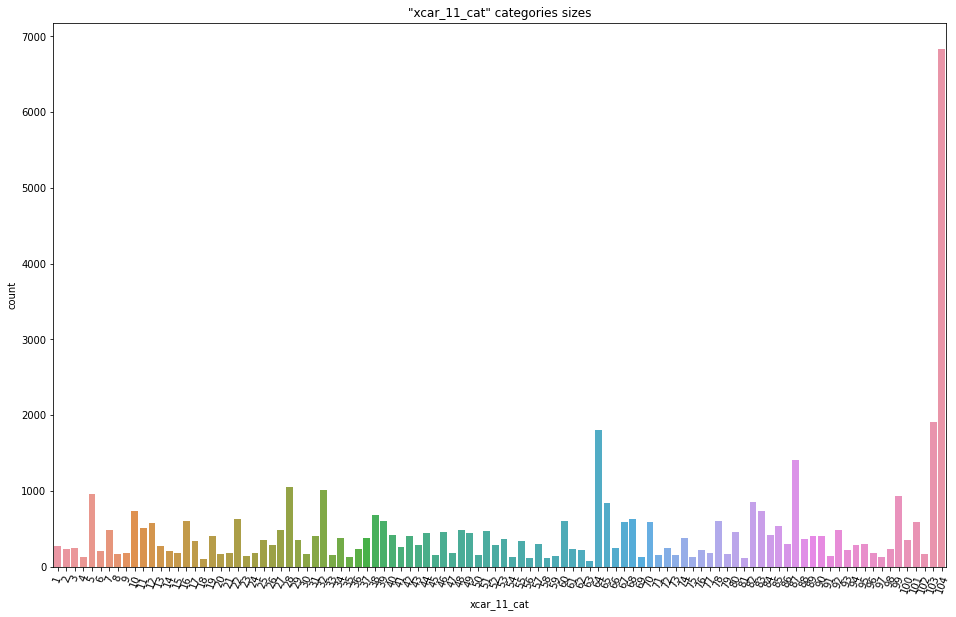

In [23]:
df = train_sample_df

print(f"Categorical columns: {getCategoricalColumns(df)}\n")

feature = 'xcar_11_cat' # CHOOSE FEATURE HERE - easy to copy from below

_ = showSizesOfFeatureCategories(feature, df)

del df, feature

### One-hot Encoding

- Concatenate non-categorical columns with the one-hot encoding of the categorical colums.

In [24]:
train_sample_df = oneHotEncoding(train_sample_df)

train_sample_thumb_df = oneHotEncoding(train_sample_thumb_df)

Number of features after encoding: 227
Number of features after encoding: 75


### Show Features Representing Missing Values

In [25]:
print("Encoded columns that represents missing values:",
    *getEncodedCategoricalColumns("-1", train_sample_df),
sep="\n")

Encoded columns that represents missing values:
xind_02_cat_-1
xind_04_cat_-1
xind_05_cat_-1
xcar_01_cat_-1
xcar_03_cat_-1
xcar_05_cat_-1
xcar_07_cat_-1
xcar_09_cat_-1


### Drop columns representing missing values

I chosed to drop the columns representing missing values.
- Certainly there are better ways to handle this problem such as imputation methods or at least start with proper exploration of any dependencies before such an action. 

In [26]:
train_sample_thumb_df = dropMissingValuesEncodedToFeatures(train_sample_thumb_df)

print("Encoded columns that represents missing values:",
    *getEncodedCategoricalColumns("-1", train_sample_thumb_df),
sep="\n")

Encoded columns that represents missing values:


### Dataframe Shape After Cleansing

In [27]:
print(f"""Train sample dataframe:\n
Shape: {train_sample_df.shape} | shape without y feature {train_sample_df.drop('y', axis=1).shape}
Sizes y categories:""", train_sample_df.y.value_counts(), sep="\n", end="\n\n")

print(f"""Train sample dataframe (rule of a thumb):\n
Shape: {train_sample_thumb_df.shape} | shape without y feature {train_sample_thumb_df.drop('y', axis=1).shape}
Sizes of y categories:""", train_sample_thumb_df.y.value_counts(), sep="\n", end="\n\n")

Train sample dataframe:

Shape: (47617, 227) | shape without y feature (47617, 226)
Sizes y categories:
0    45926
1     1691
Name: y, dtype: int64

Train sample dataframe (rule of a thumb):

Shape: (47617, 70) | shape without y feature (47617, 69)
Sizes of y categories:
0    45926
1     1691
Name: y, dtype: int64



### Compare Thumb Rules with Minimum Cleansing Approach

In [28]:
train_sample_train_df, train_sample_val_df, train_sample_thumb_train_df, train_sample_thumb_val_df =\
train_test_split(train_sample_df, train_sample_thumb_df, test_size=VALIDATION_SET_RATIO, random_state=SEED)

train_sample_ds, val_sample_ds = datasetsFromDataframes(
    name="train_sample", train_df=train_sample_train_df, test_df=train_sample_val_df
)
train_thumb_ds, val_thumb_ds = datasetsFromDataframes(
    name="train_sample_thumb", train_df=train_sample_thumb_train_df, test_df=train_sample_thumb_val_df
)


In [29]:
%%time

cleansing_models = []

for classifier in CLASSIFIERS:
    print("\n", f" {classifier.name} ".center(79, "-"))
    
    for train_ds, val_ds in ((train_sample_ds, val_sample_ds), (train_thumb_ds, val_thumb_ds)):
        %time cleansing_models.append(trainModel(classifier, train_ds, val_ds))
    
del classifier, train_ds, val_ds; print(f"\n{' Total cell execution time '.center(79, '#')}\n")


 -------------------------------- decision_tree --------------------------------

[decision_tree] train_sample
CPU times: user 2.58 s, sys: 14.5 ms, total: 2.59 s
Wall time: 2.59 s

[decision_tree] train_sample_thumb
CPU times: user 752 ms, sys: 3.48 ms, total: 755 ms
Wall time: 754 ms

 --------------------------------- naive_bayes ---------------------------------

[naive_bayes] train_sample
CPU times: user 121 ms, sys: 20.1 ms, total: 141 ms
Wall time: 141 ms

[naive_bayes] train_sample_thumb
CPU times: user 72.6 ms, sys: 3.9 ms, total: 76.5 ms
Wall time: 75.6 ms

 ----------------------------- logistic_regression -----------------------------

[logistic_regression] train_sample


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 2min 1s, sys: 1min 16s, total: 3min 17s
Wall time: 27.3 s

[logistic_regression] train_sample_thumb
CPU times: user 1min 12s, sys: 1min 6s, total: 2min 18s
Wall time: 19.1 s

 ---------------------------- multilayer_perceptron ----------------------------

[multilayer_perceptron] train_sample
CPU times: user 2min 38s, sys: 3min 43s, total: 6min 21s
Wall time: 49.5 s

[multilayer_perceptron] train_sample_thumb
CPU times: user 1min 24s, sys: 2min 7s, total: 3min 31s
Wall time: 26.8 s

########################## Total cell execution time ##########################

CPU times: user 7min 20s, sys: 8min 13s, total: 15min 34s
Wall time: 2min 6s


In [30]:
cleansing_evals = []
        
for model in cleansing_models:
    cleansing_evals.append(evaluateModel(model))

[decision_tree]          train_sample             Acc: 0.92461	AUC: 0.50477	F1: 0.04775
[decision_tree]          train_sample_thumb       Acc: 0.91758	AUC: 0.50668	F1: 0.05308
[naive_bayes]            train_sample             Acc: 0.19467	AUC: 0.49872	F1: 0.06940
[naive_bayes]            train_sample_thumb       Acc: 0.04021	AUC: 0.49923	F1: 0.07000
[logistic_regression]    train_sample             Acc: 0.96367	AUC: 0.50000	F1: 0.00000
[logistic_regression]    train_sample_thumb       Acc: 0.96367	AUC: 0.50000	F1: 0.00000
[multilayer_perceptron]  train_sample             Acc: 0.96367	AUC: 0.50000	F1: 0.00000
[multilayer_perceptron]  train_sample_thumb       Acc: 0.96367	AUC: 0.50000	F1: 0.00000


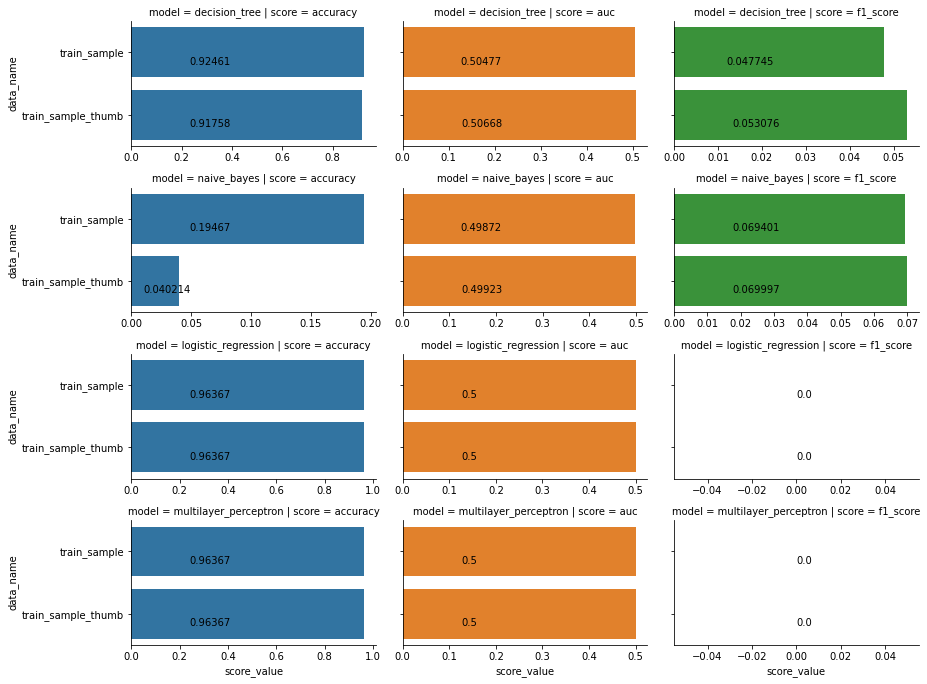

In [31]:
_ = showEvaluations(cleansing_evals)

## Binning

In [32]:
binning_df = train_sample_thumb_df.copy()

#### Show the Features with Highest Cardinality

I chosed to discretize the highest cardinality feature i.e. the fature with the biggest number of unique values.

In [33]:
binning_df.nunique().sort_values(ascending=False)[:5]

xcar_13     21209
xcar_14       689
xcar_12       113
xcalc_10       23
xcalc_14       21
dtype: int64

In [34]:
binning_feature = "xcar_13"

The feature "xcar_13" has the biggest number of unique values by a lot so I will apply binning to it.

### Histogram of xcar_13 (values distribution)

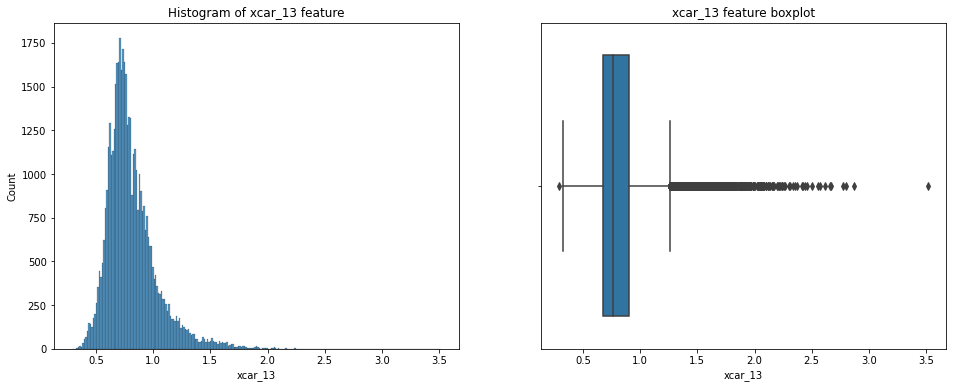

In [35]:
showHistogramAndBoxplot(binning_feature, binning_df, discrete=None)

Before I start with binning I will create a sample copy of the dataframe to do the test 

### Binning Function

### Equal Width Binning

#### Number of bins

- As a rule of thumb i chosed to take square root of unique values rounded up.

Number of Intervals: 5
Name of binned feature: xcar_13_width_5


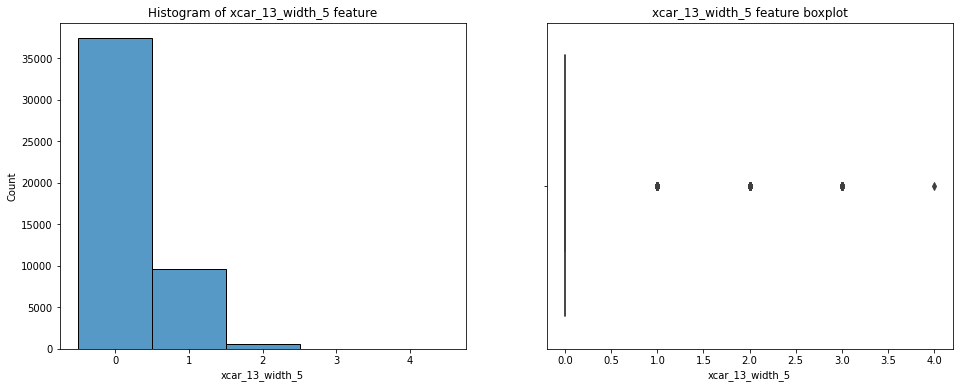

In [36]:
feature_width_log10 = binFeatureEqualWidth(binning_feature, binning_df, equal="width", interval_method=np.log10)

showHistogramAndBoxplot(feature_width_log10, binning_df, discrete=True)

Number of Intervals: 15
Name of binned feature: xcar_13_width_15


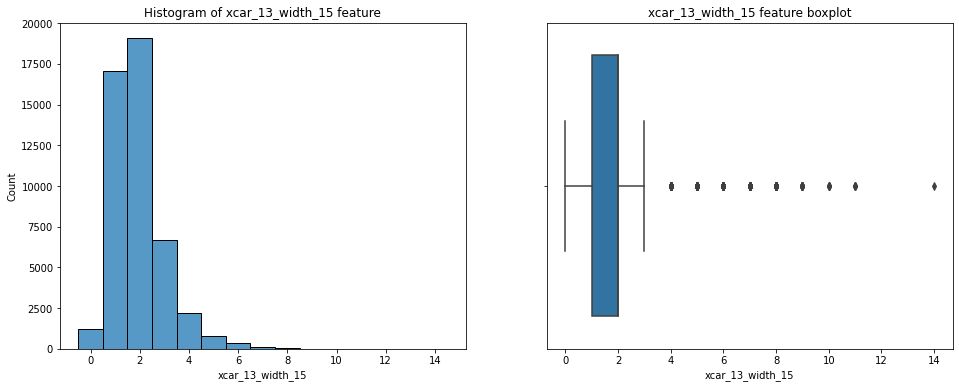

In [37]:
feature_width_log2 = binFeatureEqualWidth(binning_feature, binning_df, equal="width", interval_method=np.log2)

showHistogramAndBoxplot(feature_width_log2, binning_df, discrete=True)

Number of Intervals: 28
Name of binned feature: xcar_13_width_28


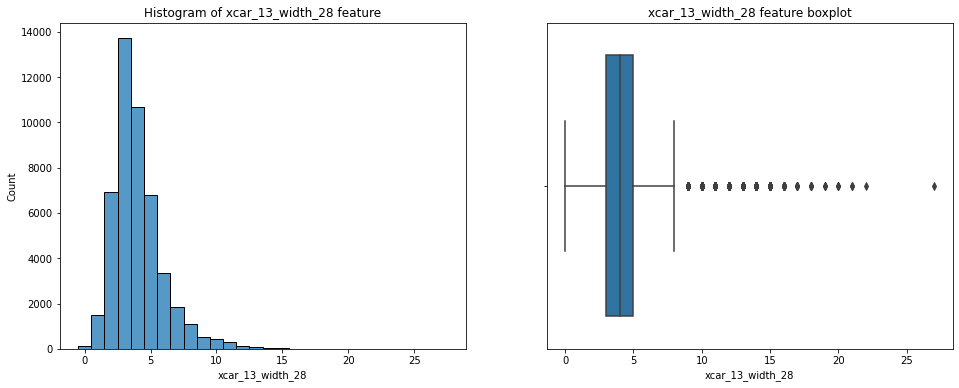

In [38]:
feature_width_cbrt = binFeatureEqualWidth(binning_feature, binning_df, equal="width", interval_method=np.cbrt)

showHistogramAndBoxplot(feature_width_cbrt, binning_df, discrete=True)

Number of Intervals: 146
Name of binned feature: xcar_13_width_146


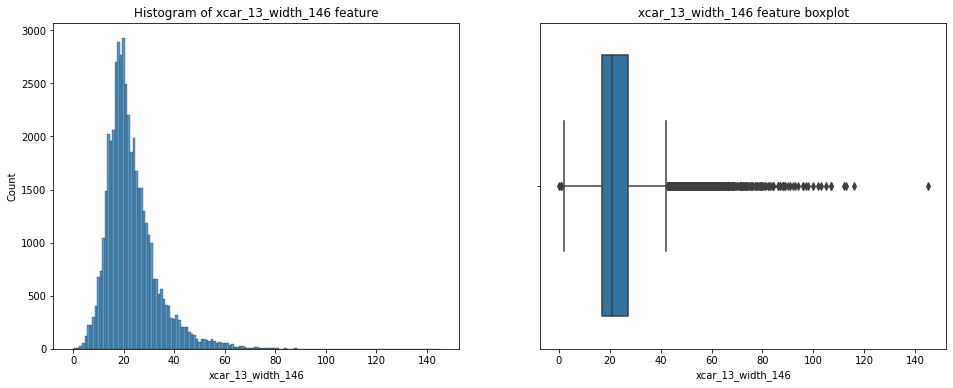

In [39]:
feature_width_sqrt = binFeatureEqualWidth(binning_feature, binning_df, equal="width", interval_method=np.sqrt)

showHistogramAndBoxplot(feature_width_sqrt, binning_df, discrete=True)

### Equal Depth Binning

Number of Intervals: 5
Name of binned feature: xcar_13_depth_5


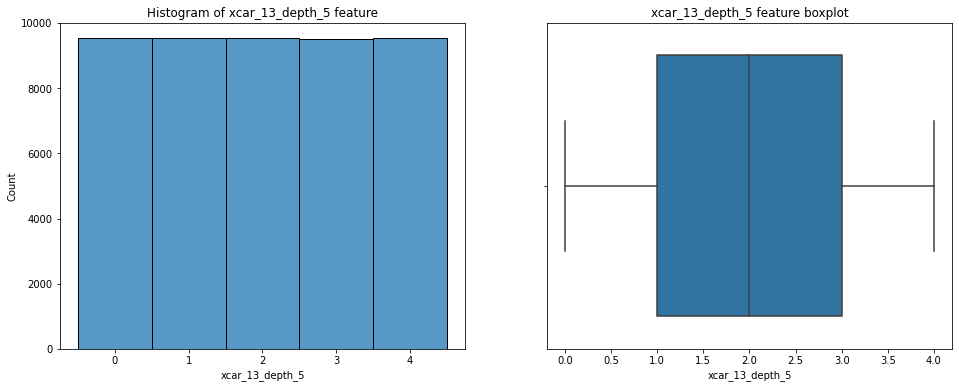

In [40]:
feature_depth_log10 = binFeatureEqualWidth(binning_feature, binning_df, equal="depth", interval_method=np.log10)

showHistogramAndBoxplot(feature_depth_log10, binning_df, discrete=True)

Number of Intervals: 15
Name of binned feature: xcar_13_depth_15


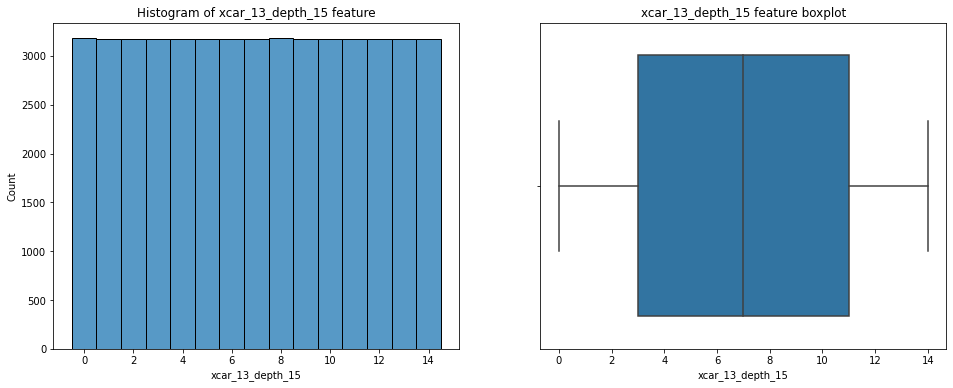

In [41]:
feature_depth_log2 = binFeatureEqualWidth(binning_feature, binning_df, equal="depth", interval_method=np.log2)

showHistogramAndBoxplot(feature_depth_log2, binning_df, discrete=True)

Number of Intervals: 28
Name of binned feature: xcar_13_depth_28


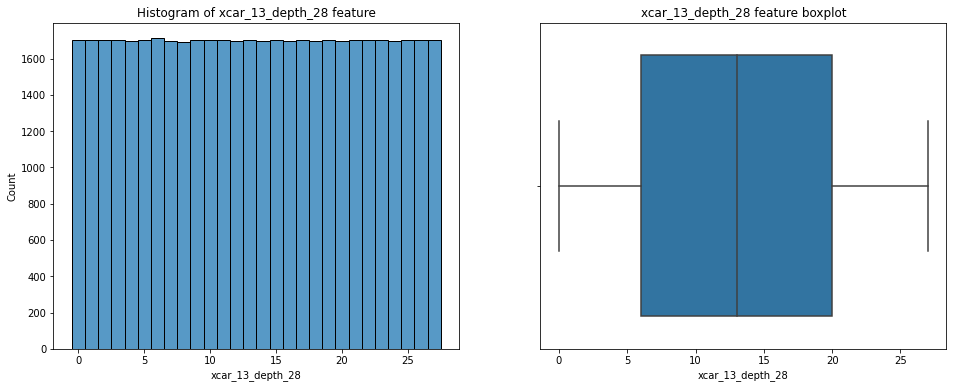

In [42]:
feature_depth_cbrt = binFeatureEqualWidth(binning_feature, binning_df, equal="depth", interval_method=np.cbrt)

showHistogramAndBoxplot(feature_depth_cbrt, binning_df, discrete=True)

Number of Intervals: 146
Name of binned feature: xcar_13_depth_146


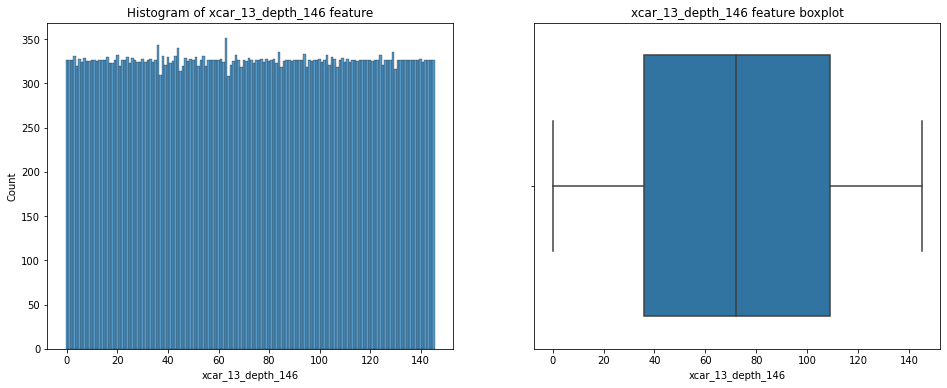

In [43]:
feature_depth_sqrt = binFeatureEqualWidth(binning_feature, binning_df, equal="depth", interval_method=np.sqrt)

showHistogramAndBoxplot(feature_depth_sqrt, binning_df, discrete=True)

In [44]:
alternating_cols = [x for x in binning_df.columns if (("_width" in x) or ("_depth" in x))]
alternating_cols.append(alternating_cols[0].split("_width")[0].split("_depth")[0])
display(alternating_cols)

bin_train_df, bin_val_df = train_test_split(binning_df, test_size=VALIDATION_SET_RATIO, random_state=SEED)

['xcar_13_width_5',
 'xcar_13_width_15',
 'xcar_13_width_28',
 'xcar_13_width_146',
 'xcar_13_depth_5',
 'xcar_13_depth_15',
 'xcar_13_depth_28',
 'xcar_13_depth_146',
 'xcar_13']

#### The models are trained with X features, where is present only one column form alternating_cols at a time.

In [45]:
%%time

binning_models = []

for classifier in CLASSIFIERS:
    print("\n", f" {classifier.name} ".center(79, "-"))

    for feature in alternating_cols:
        # Prepare train and validation datasetsDrop alternating columns 
        drop_features = [x for x in alternating_cols if x != feature]
        train_ds, val_ds = datasetsFromDataframes(name=feature, train_df=bin_train_df, test_df=bin_val_df,
            drop_features=drop_features)
        %time binning_models.append(trainModel(classifier, train_ds, val_ds))
    
del classifier, feature, drop_features, train_ds, val_ds; print(f"\n{' Total cell execution time '.center(79, '#')}\n")


 -------------------------------- decision_tree --------------------------------

[decision_tree] xcar_13_width_5
CPU times: user 729 ms, sys: 514 µs, total: 729 ms
Wall time: 728 ms

[decision_tree] xcar_13_width_15
CPU times: user 680 ms, sys: 381 µs, total: 680 ms
Wall time: 679 ms

[decision_tree] xcar_13_width_28
CPU times: user 677 ms, sys: 0 ns, total: 677 ms
Wall time: 677 ms

[decision_tree] xcar_13_width_146
CPU times: user 680 ms, sys: 0 ns, total: 680 ms
Wall time: 680 ms

[decision_tree] xcar_13_depth_5
CPU times: user 687 ms, sys: 2.39 ms, total: 689 ms
Wall time: 688 ms

[decision_tree] xcar_13_depth_15
CPU times: user 678 ms, sys: 1.48 ms, total: 680 ms
Wall time: 678 ms

[decision_tree] xcar_13_depth_28
CPU times: user 680 ms, sys: 0 ns, total: 680 ms
Wall time: 679 ms

[decision_tree] xcar_13_depth_146
CPU times: user 709 ms, sys: 167 µs, total: 709 ms
Wall time: 708 ms

[decision_tree] xcar_13
CPU times: user 733 ms, sys: 358 µs, total: 733 ms
Wall time: 732 ms

 --

/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 9s, sys: 56.6 s, total: 2min 6s
Wall time: 15.9 s

[logistic_regression] xcar_13_width_15
CPU times: user 1min 8s, sys: 55.6 s, total: 2min 4s
Wall time: 15.7 s

[logistic_regression] xcar_13_width_28
CPU times: user 1min 6s, sys: 1min, total: 2min 7s
Wall time: 17.1 s

[logistic_regression] xcar_13_width_146


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 12s, sys: 1min 1s, total: 2min 14s
Wall time: 17.4 s

[logistic_regression] xcar_13_depth_5
CPU times: user 1min 4s, sys: 59.1 s, total: 2min 4s
Wall time: 16.3 s

[logistic_regression] xcar_13_depth_15
CPU times: user 1min 10s, sys: 1min 2s, total: 2min 12s
Wall time: 17.4 s

[logistic_regression] xcar_13_depth_28


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 20s, sys: 1min 17s, total: 2min 38s
Wall time: 22.2 s

[logistic_regression] xcar_13_depth_146


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 24s, sys: 1min 18s, total: 2min 42s
Wall time: 22.6 s

[logistic_regression] xcar_13
CPU times: user 1min 2s, sys: 51.2 s, total: 1min 53s
Wall time: 14.3 s

 ---------------------------- multilayer_perceptron ----------------------------

[multilayer_perceptron] xcar_13_width_5
CPU times: user 1min 25s, sys: 2min 6s, total: 3min 32s
Wall time: 26.6 s

[multilayer_perceptron] xcar_13_width_15
CPU times: user 1min 27s, sys: 2min 12s, total: 3min 39s
Wall time: 27.9 s

[multilayer_perceptron] xcar_13_width_28
CPU times: user 1min 26s, sys: 2min 10s, total: 3min 37s
Wall time: 27.4 s

[multilayer_perceptron] xcar_13_width_146
CPU times: user 1min 57s, sys: 2min 56s, total: 4min 53s
Wall time: 36.9 s

[multilayer_perceptron] xcar_13_depth_5
CPU times: user 1min 26s, sys: 2min 6s, total: 3min 33s
Wall time: 26.8 s

[multilayer_perceptron] xcar_13_depth_15
CPU times: user 1min 25s, sys: 2min 10s, total: 3min 36s
Wall time: 27.1 s

[multilayer_perceptron] xcar_13_depth_28

In [46]:
binning_evals = []
        
for model in binning_models:
    binning_evals.append(evaluateModel(model))

[decision_tree]          xcar_13_width_5          Acc: 0.92041	AUC: 0.50676	F1: 0.05250
[decision_tree]          xcar_13_width_15         Acc: 0.92052	AUC: 0.50681	F1: 0.05257
[decision_tree]          xcar_13_width_28         Acc: 0.91327	AUC: 0.49888	F1: 0.04176
[decision_tree]          xcar_13_width_146        Acc: 0.91453	AUC: 0.49675	F1: 0.03783
[decision_tree]          xcar_13_depth_5          Acc: 0.92020	AUC: 0.50943	F1: 0.05707
[decision_tree]          xcar_13_depth_15         Acc: 0.91863	AUC: 0.50305	F1: 0.04674
[decision_tree]          xcar_13_depth_28         Acc: 0.91999	AUC: 0.49959	F1: 0.04030
[decision_tree]          xcar_13_depth_146        Acc: 0.91684	AUC: 0.50491	F1: 0.05036
[decision_tree]          xcar_13                  Acc: 0.91758	AUC: 0.50668	F1: 0.05308
[naive_bayes]            xcar_13_width_5          Acc: 0.04021	AUC: 0.49923	F1: 0.07000
[naive_bayes]            xcar_13_width_15         Acc: 0.04021	AUC: 0.49923	F1: 0.07000
[naive_bayes]            xcar_13

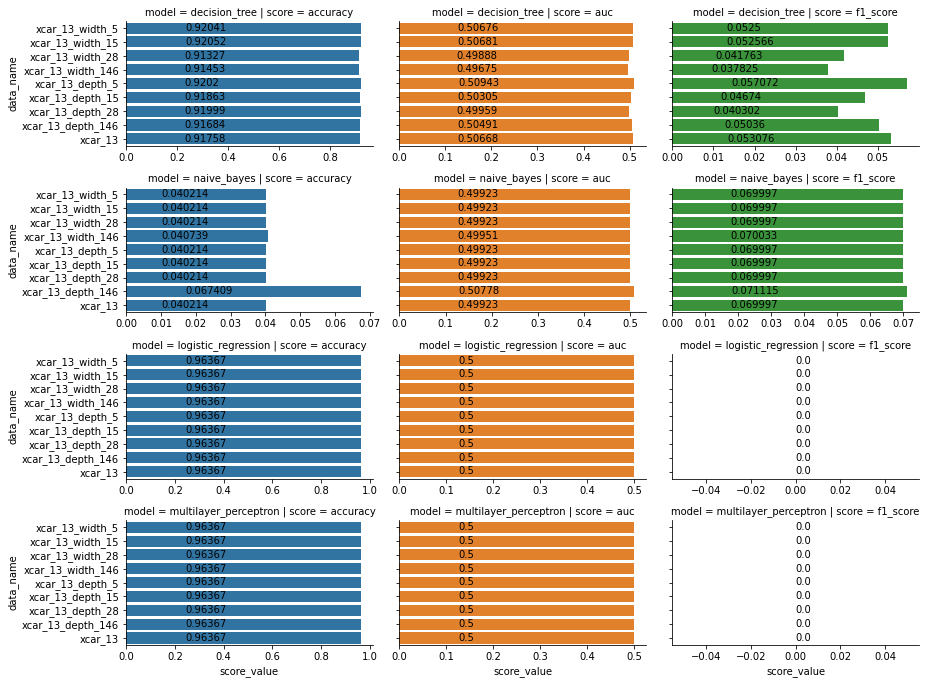

In [47]:
_ = showEvaluations(binning_evals)

### Save Models

- MemoryError (is what it have got)

```py
---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
<ipython-input-49-6c3818c13f56> in <module>
      1 if True: # SAVE MODELS
      2     for model in trained_models:
----> 3         pickle.dump(model, open(f"binning_{model[0].name}.pkl", "wb"))

MemoryError:
```

In [48]:
if False: # SAVE MODELS
    for model in binning_models:
        pickle.dump(model, open(f"binning_{model.classifier.name}_{model.train_set.name}.pkl", "wb"))

## Balancing

In [49]:
balancing_df = train_sample_thumb_df.copy()

In [50]:
df = balancing_df

print("Number of rows per y category:")
display(df.y.value_counts())

print(f"\nShape of the balancing dataframe: {df.shape}")
      
print("\n\nBalancing dataframe sample:")
display(df.sample(n=10))

del df

Number of rows per y category:


0    45926
1     1691
Name: y, dtype: int64


Shape of the balancing dataframe: (47617, 70)


Balancing dataframe sample:


,y,xind_01,xind_03,xind_06_bin,xind_07_bin,xind_08_bin,xind_09_bin,xind_10_bin,xind_11_bin,xind_12_bin,...,xcar_08_cat_0,xcar_08_cat_1,xcar_09_cat_0,xcar_09_cat_1,xcar_09_cat_2,xcar_09_cat_3,xcar_09_cat_4,xcar_10_cat_0,xcar_10_cat_1,xcar_10_cat_2
396904,1,3,4,0,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
98558,0,6,3,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
423688,0,0,8,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
449272,0,3,3,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
308655,0,5,1,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
310219,0,5,7,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
184334,0,0,4,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
148874,0,2,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
142867,0,3,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
266330,0,1,7,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0


### Split balancing dataframe into train dataset and validation dataset

In [51]:
bal_train_df, bal_val_df = train_test_split(balancing_df, test_size=VALIDATION_SET_RATIO, random_state=SEED)

bal_train_ds = Dataset("bal_train_original", bal_train_df.drop("y", axis=1,), bal_train_df.y)
bal_val_ds = Dataset("bal_val_original", bal_val_df.drop("y", axis=1), bal_val_df.y)

### Reference Set without Balancing

### Under-sampling

- One Sided Selection 
    - CPU total: 6h 47min 28s, Wall time: 6h 47min 29s
- Tomek Links
    - CPU total: 6h 10min 40s, Wall time: 6h 10min 40s

In [52]:
np.random.seed(seed=SEED)

balancers_under = (
    Balancer(name="random_under_sampling", method=RandomUnderSampler(random_state=SEED)),
    Balancer(name="one_sided_selection", method=OneSidedSelection(random_state=SEED)),
    Balancer(name="tomek_links", method=TomekLinks()),
)

### Over-sampling methods

- Random Over-sampling
- SMOTE

In [53]:
balancers_over = (
    Balancer(name="random_over_sampling", method=RandomOverSampler(random_state=SEED)),
    Balancer(name="smote", method=SMOTE(random_state=SEED))
)

### Over and Under Sampling Combination

In [54]:
balancers_combi = (
    Balancer(name="smote_tomek", method=SMOTETomek(random_state=SEED)),
)

### Perform the Training Set Balancing

In [55]:
%%time

balanced_train_sets = [bal_train_ds]

for balancers in (balancers_under, balancers_over, balancers_combi):
    for balancer in balancers:
        print("\n", f" {balancer.name} ".center(79, "-"))
        %time balanced_train_sets.append(Dataset(balancer.name, *balancer.method.fit_sample(bal_train_ds.X, bal_train_ds.y)))

del balancers, balancer; print(f"\n{' Total cell execution time '.center(79, '#')}\n")


 ---------------------------- random_under_sampling ----------------------------
CPU times: user 32 ms, sys: 8.23 ms, total: 40.3 ms
Wall time: 39.7 ms

 ----------------------------- one_sided_selection -----------------------------
CPU times: user 1min 51s, sys: 1.58 ms, total: 1min 51s
Wall time: 1min 51s

 --------------------------------- tomek_links ---------------------------------
CPU times: user 1min 45s, sys: 0 ns, total: 1min 45s
Wall time: 1min 45s

 ----------------------------- random_over_sampling ----------------------------
CPU times: user 105 ms, sys: 4.19 ms, total: 109 ms
Wall time: 109 ms

 ------------------------------------ smote ------------------------------------
CPU times: user 289 ms, sys: 16.6 ms, total: 305 ms
Wall time: 305 ms

 --------------------------------- smote_tomek ---------------------------------
CPU times: user 2min 49s, sys: 148 µs, total: 2min 49s
Wall time: 2min 49s

########################## Total cell execution time ###################

In [56]:
%%time

balanced_models = []

for classifier in CLASSIFIERS:
    print("\n", f" {classifier.name} ".center(79, "-"), sep="")
    for train_ds in balanced_train_sets:
        %time balanced_models.append(trainModel(classifier, train_ds, bal_val_ds))
        
del classifier, train_ds; print(f"\n{' Total cell execution time '.center(79, '#')}\n")


-------------------------------- decision_tree --------------------------------

[decision_tree] bal_train_original
CPU times: user 706 ms, sys: 1.13 ms, total: 707 ms
Wall time: 704 ms

[decision_tree] random_under_sampling
CPU times: user 65.8 ms, sys: 0 ns, total: 65.8 ms
Wall time: 66.4 ms

[decision_tree] one_sided_selection
CPU times: user 712 ms, sys: 0 ns, total: 712 ms
Wall time: 712 ms

[decision_tree] tomek_links
CPU times: user 750 ms, sys: 3.16 ms, total: 754 ms
Wall time: 756 ms

[decision_tree] random_over_sampling
CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.26 s

[decision_tree] smote
CPU times: user 2.1 s, sys: 14.9 ms, total: 2.11 s
Wall time: 2.12 s

[decision_tree] smote_tomek
CPU times: user 2.2 s, sys: 5.86 ms, total: 2.2 s
Wall time: 2.2 s

--------------------------------- naive_bayes ---------------------------------

[naive_bayes] bal_train_original
CPU times: user 42.6 ms, sys: 2.94 ms, total: 45.5 ms
Wall time: 45 ms

[naive_bayes] random_

/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 17s, sys: 1min 7s, total: 2min 24s
Wall time: 19.1 s

[logistic_regression] tomek_links
CPU times: user 1min 14s, sys: 1min 7s, total: 2min 22s
Wall time: 19.2 s

[logistic_regression] random_over_sampling


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 2min 28s, sys: 2min 8s, total: 4min 36s
Wall time: 37.2 s

[logistic_regression] smote


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 2min 24s, sys: 1min 55s, total: 4min 20s
Wall time: 34.4 s

[logistic_regression] smote_tomek


/home/langerjaros/.langerenv_0.2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 2min 17s, sys: 1min 47s, total: 4min 5s
Wall time: 31.8 s

---------------------------- multilayer_perceptron ----------------------------

[multilayer_perceptron] bal_train_original
CPU times: user 1min 24s, sys: 2min 4s, total: 3min 29s
Wall time: 26.3 s

[multilayer_perceptron] random_under_sampling
CPU times: user 27.6 s, sys: 42.7 s, total: 1min 10s
Wall time: 8.85 s

[multilayer_perceptron] one_sided_selection
CPU times: user 1min 19s, sys: 1min 57s, total: 3min 17s
Wall time: 24.9 s

[multilayer_perceptron] tomek_links
CPU times: user 1min 21s, sys: 2min 2s, total: 3min 24s
Wall time: 25.6 s

[multilayer_perceptron] random_over_sampling
CPU times: user 8min 24s, sys: 12min 58s, total: 21min 22s
Wall time: 2min 46s

[multilayer_perceptron] smote
CPU times: user 4min 6s, sys: 6min 59s, total: 11min 6s
Wall time: 1min 31s

[multilayer_perceptron] smote_tomek
CPU times: user 4min 5s, sys: 6min 55s, total: 11min 1s
Wall time: 1min 32s

########################## Total

### Evaluate Balancing Methods

In [57]:
balancing_evals = []

# trained_models = (original_ref_models, under_sampled_models, over_sampled_models, combi)

for model in balanced_models:
        balancing_evals.append(evaluateModel(model))

[decision_tree]          bal_train_original       Acc: 0.91758	AUC: 0.50668	F1: 0.05308
[decision_tree]          random_under_sampling    Acc: 0.52730	AUC: 0.52390	F1: 0.07404
[decision_tree]          one_sided_selection      Acc: 0.91674	AUC: 0.49373	F1: 0.03175
[decision_tree]          tomek_links              Acc: 0.91821	AUC: 0.49588	F1: 0.03470
[decision_tree]          random_over_sampling     Acc: 0.92619	AUC: 0.51114	F1: 0.05890
[decision_tree]          smote                    Acc: 0.90949	AUC: 0.51361	F1: 0.06508
[decision_tree]          smote_tomek              Acc: 0.90949	AUC: 0.51361	F1: 0.06508
[naive_bayes]            bal_train_original       Acc: 0.04021	AUC: 0.49923	F1: 0.07000
[naive_bayes]            random_under_sampling    Acc: 0.09828	AUC: 0.51685	F1: 0.07237
[naive_bayes]            one_sided_selection      Acc: 0.04021	AUC: 0.49923	F1: 0.07000
[naive_bayes]            tomek_links              Acc: 0.04021	AUC: 0.49923	F1: 0.07000
[naive_bayes]            random_

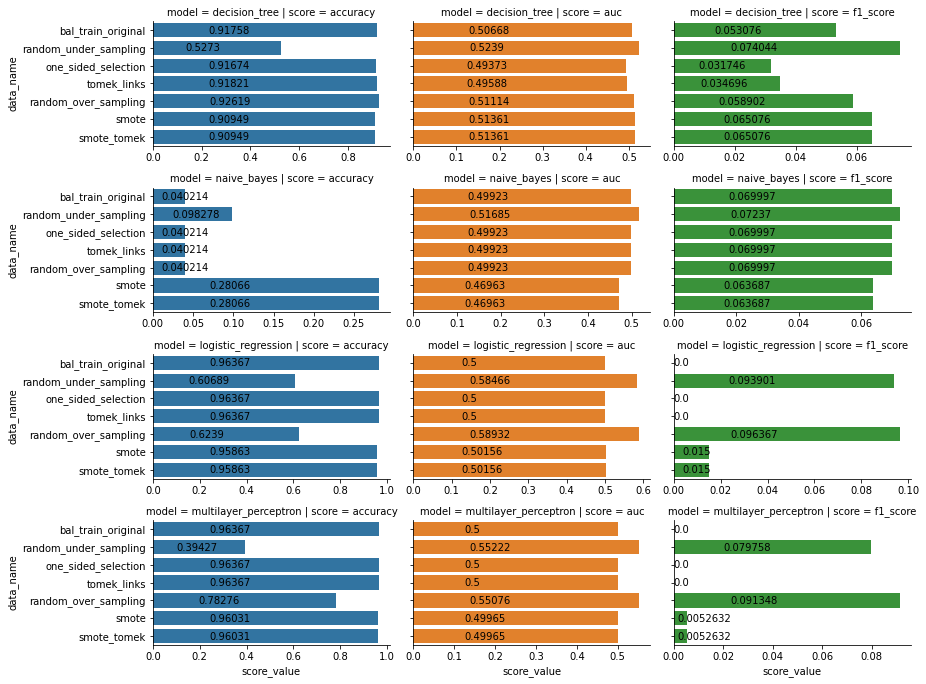

In [58]:
_ = showEvaluations(balancing_evals)

## Classification Tests and Evalutaions

In [ ]:
df = train_df

print(f"Shape of the train dataframe: {df.shape} (rows, columns)\n",
      "Sizes of y groups:", sep="\n")
display(df.y.value_counts())

del df

In [ ]:
# df = sample_df

# df[df["y"] == 1]

# sample_size = min(df.y.value_counts()[1], required_rows)
# # sample_size
# sample = sample_df.groupby("y").sample(sample_size)

### Divide the dataset into train set and test set

In [ ]:
train_ds = Dataset(train_df.drop("y", axis=1), train_df.y)

test_df = convertCategoricalFeatures(test_df)
test_df = oneHotEncoding(test_df)
test_ds = Dataset(test_df.drop("y", axis=1),  test_df.y)

In [ ]:
# df = sample_df

# ds = Dataset(df.drop("y", axis=1), df.y)

# X_train, X_test, y_train, y_test = train_test_split(ds.X, ds.y, test_size=0.20, random_state=SEED)
# train_ds, test_ds = Dataset(X_train, y_train), Dataset(X_test, y_test)

In [ ]:
print(f"""Train Set and Test Set Sizes (rows, columns)
Train set: X={train_ds.X.shape}, y={train_ds.y.shape}
Test set:  X={test_ds.X.shape}, y={test_ds.y.shape}
""")

### Classifiers and Predictions

### k-Means (2)

In [ ]:
# %%time

# km = KMeans(n_clusters=2, random_state=SEED)

# y_pred_km = km.fit(train_ds.X, train_ds.y).predict(test_ds.X)

# # Structure the data together
# km_model = Model(name="k_means", classifier=km, 
#     train_set=train_ds, test_set=test_ds, y_prediction=y_pred_km
# ) 

### Decision Tree Learning and Prediciton

In [ ]:
%%time

dtc = DecisionTreeClassifier(random_state=SEED)
y_pred_dtc = dtc.fit(train_ds.X, train_ds.y).predict(test_ds.X)

dtc_model = Model(name="decision_tree", classifier=dtc, y_prediction=y_pred_dtc,
    train_set=train_ds, test_set=test_ds) 

### Naive Bayes

In [ ]:
%%time

gnb = GaussianNB()
y_pred_gnb = gnb.fit(train_ds.X, train_ds.y).predict(test_ds.X)

gnb_model = Model(name="naive_bayes", classifier=gnb, y_prediction=y_pred_gnb,
    train_set=train_ds, test_set=test_ds) 

### Logistic Regression

In [ ]:
%%time

lr = LogisticRegression(max_iter=1000, random_state=SEED)
y_pred_lr = lr.fit(train_ds.X, train_ds.y).predict(test_ds.X)

# Structure the data together
lr_model = Model(name="logistic_regression", classifier=lr, 
    train_set=train_ds, test_set=test_ds, y_prediction=y_pred_lr
) 

### Radial Basis Function SVM

In [ ]:
# %%time

# svc = SVC(gamma=2, C=1)
# y_pred_svc = svc.fit(train_ds.X, train_ds.y).predict(test_ds.X)

# svc_model = Model(name="RBF_SVM", classifier=svc, y_prediction=y_pred_svc,
#     train_set=train_ds, test_set=test_ds)

### Multilayer Perceptron

In [ ]:
%%time

# mlp = MLPClassifier(hidden_layer_sizes=(HIDDEN_NEURONS, ), alpha=1, max_iter=1000, random_state=SEED)
# mlp = MLPClassifier(hidden_layer_sizes=(75, 75), alpha=1, max_iter=1000, random_state=SEED) CPU times: 34min 31s Wall time: 4min 22s
mlp = MLPClassifier(hidden_layer_sizes=(50, 50, 50, 50, 50), alpha=1, max_iter=1000, random_state=SEED)
y_pred_mlp = mlp.fit(train_ds.X, train_ds.y).predict(test_ds.X)

mlp_model = Model(name="multilayer_perceptron", classifier=mlp, y_prediction=y_pred_mlp,
    train_set=train_ds, test_set=test_ds)

### k-Nearest Neighbors

In [ ]:
# %%time

# knn = KNeighborsClassifier()
# y_pred_knn = knn.fit(train_ds.X, train_ds.y).predict(test_ds.X)

# knn_model = Model(name="k_nearest_neighbors", classifier=knn, y_prediction=y_pred_knn,
#     train_set=train_ds, test_set=test_ds) 

### Show models parameters

In [ ]:
# MODELS = (dtc_model, gnb_model, lr_model, svc_model, mlp_model, knn_model)
MODELS = (dtc_model, gnb_model, lr_model, mlp_model)

for model in MODELS:
    print(f"\"{model.name}\", {model.classifier.estimator.get_params()}\n")

if False: # SAVE MODELS
    file_name = f"models_{dtc_model.train_set.X.shape[0]}_{dtc_model.train_set.X.shape[1]}.pkl"
    pickle.dump(MODELS, open(f"models/{file_name}", "wb"))

### Prediction Evaluation and Comparison

In [ ]:
evals = []

for model in MODELS:
    evals.append(evaluateModel(model, "Original Data Prediction Evaluation"))

In [ ]:
df = pd.DataFrame(evals)

g = sns.PairGrid(df, x_vars=["accuracy", "auc", "f1_score"], y_vars=["model_name"], height=4)
_ = g.map(sns.barplot)

### Simple check of model train set

In [ ]:
MODELS[0].train_set.X

## IF THERE WILL BE TIME LEFT

In [ ]:
# [x for x in zip(["x_train","x_test"], ["y_train","y_test"])]
a, b = zip(["x_train","x_test"], ["y_train","y_test"])

# a, b = zip(train_test_split(df.drop('y', axis=1), test_size=0.33, random_state=SEED), ["y_train","y_test"])
# test_ds = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [ ]:
id(main_df) == id(df)

In [ ]:
# sample_df = sample_df.drop(alternating_cols, axis=1)

In [ ]:
MAX_SAMPLES_NUMBER = floor(min(df.y.value_counts())*2)

print(f"\nMaximum number of sample rows: {MAX_SAMPLES_NUMBER}")

### Minimum number of rows for given number of features

In [ ]:
df = sample_df

multiple = 3

features = (df.shape[1] - 1)

required_rows = ((features+1)*HIDDEN_NEURONS*3) # -1 for y, +1 for y
print(f"Number of required rows: {required_rows}")

In [ ]:
print("hello")

In [ ]:
%%time
# CPU times: user 4min 15s, sys: 2.89 s, total: 4min 18s
# Wall time: 4min 18s

model_name="decision_tree"
classifier = DecisionTreeClassifier(random_state=SEED)

trained_models_dtc = trainWithAlternatingColumn(model_name=model_name, classifier=classifier, 
    alternating_cols=alternating_cols, train_df=bin_train_df, val_df=bin_val_df)

In [ ]:
%%time
# CPU times: user 10.8 s, sys: 25.6 s, total: 36.3 s
# Wall time: 37.9 s

model_name = "naive_bayes"
classifier = GaussianNB()

trained_models_gnb = trainWithAlternatingColumn(model_name=model_name, classifier=classifier, 
    alternating_cols=alternating_cols, train_df=bin_train_df, val_df=bin_val_df)

In [ ]:
%%time
# CPU times: user 2h 47min 56s, sys: 1h 9min 50s, total: 3h 57min 46s
# Wall time: 30min 36s

model_name = "logistic_regression"
classifier = LogisticRegression(max_iter=1000, random_state=SEED)

trained_models_lr = trainWithAlternatingColumn(model_name=model_name, classifier=classifier, 
    alternating_cols=alternating_cols, train_df=bin_train_df, val_df=bin_val_df)

In [ ]:
%%time
# CPU times: user 2h 28min 36s, sys: 3h 3min 9s, total: 5h 31min 46s
# Wall time: 41min 43s

model_name = "multilayer_perceptron"
classifier = MLPClassifier(hidden_layer_sizes=(50, 50, 50, 50, 50), alpha=1, max_iter=1000, random_state=SEED)

trained_models_mlp = trainWithAlternatingColumn(model_name=model_name, classifier=classifier, 
    alternating_cols=alternating_cols, train_df=bin_train_df, val_df=bin_val_df)

In [ ]:
trained_models = (trained_models_dtc, trained_models_gnb, trained_models_lr, trained_models_mlp)
# trained_models = (trained_models_gnb, )

# for models in trained_models:
#     for model in models: #, gnb_model, lr_model]: #
    
# "Original Data Prediction Evaluation"

In [ ]:
%%time

balanced_train_sets = []

for balancer in balancers_under:
    print("\n", f" {balancer.name} ".center(79, "-"))
    %time balanced_train_sets.append(Dataset(balancer.name, *balancer.method.fit_sample(bal_train_ds.X, bal_train_ds.y)))

In [ ]:
over_sampled_models = []

for name, classifier in classifiers:
    for balancer in balancers_over:
        %time over_sampled_models.append(trainWithBalancedSets(name, classifier, balancer, bal_train_ds, bal_val_ds))


In [ ]:
combi_sampled_models = []

for name, classifier in classifiers:
    for balancer in balancers_combi:
        %time combi_sampled_models.append(trainWithBalancedSets(name, classifier, balancer, bal_train_ds, bal_val_ds))